In [1]:
%matplotlib inline

from collections import defaultdict, Counter
import glob
import os

from IPython.core.display import HTML, Image
from matplotlib_venn import venn3
import pandas as pd
import pybedtools
import pysam
import seaborn as sns
from scipy.stats import ttest_ind
from gscripts.rnaseq import helpers
from gscripts.general import parsers
from gscripts.general import region_helpers
import numpy as np
import seaborn as sns
import matplotlib

img_dir = "/nas3/gpratt/Dropbox/TAF15/Data/sALS/"

In [2]:
gene_id_to_name = region_helpers.gene_id_to_name("/nas3/gpratt/gencode/gencode.v17.annotation.gtf.db")
gene_id_to_type = region_helpers.gene_id_to_type("/nas3/gpratt/gencode/gencode.v17.annotation.gtf.db")


In [3]:
analysis_dir = "/nas3/gpratt/projects/fet_family/analysis/sALS_v1/"
fet_clip = parsers.rnaseq_metrics(analysis_dir)

fet_clip["Reads After Triming"] = fet_clip['Input Reads'] - fet_clip['Too short reads']

filtered_guttman_clip = fet_clip[[ "Input Reads",
                            "Reads After Triming",
                            "Uniquely Mapped Reads",
                            "Uniquely mapped reads %",
                            
                            ]]

HTML(filtered_guttman_clip.to_html(formatters={"Input Reads" : parsers.commas,
                                     "Reads After Triming" : parsers.commas,
                                     "Reads after Quality Filtering" : parsers.commas,
                                     "Uniquely Mapped Reads" : parsers.commas,
                                     "Usable Reads" : parsers.commas,
                                     "Num Peaks": parsers.commas
                                     } ))

IndexError: list index out of range

#From Ron's RPKMs get the actual values

In [4]:
annotations = "60a	62a	63a	84a	89a	21a	34a	79a	82a	16a	27a	48a	85a	10c	65c	78c	39c	67c	76c	42c	44c	88c"
values = "-3.814658309	-3.626739883	-3.695991937	-2.83743096	-1.4892684	-4.224995833	-3.046472684	-4.148113022	-1.42487332	-3.617667053	-1.822375861	-0.68667834	0	-3.051376839	-3.942092815	-3.666000261	-4.008879741	-3.664231177	-3.886660831	-3.149979542	-3.3243866	-2.963962328"

In [5]:
scores = dict(zip(annotations.split(), map(float, values.split())))
scores = pd.Series(scores)

new_index = []
for index in scores.index:
    exp = "Control" if index[-1:] == "c" else "Disease"
    new_index.append([index[:-1], exp])

scores.index = pd.MultiIndex.from_tuples(new_index, names=['id', 'exp'])
scores = pd.DataFrame(scores, columns=['rpkm'])


In [6]:
scores['exp'] = scores.index.get_level_values(level='exp')
scores['id'] = scores.index.get_level_values(level='id')

/nas3/gpratt/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


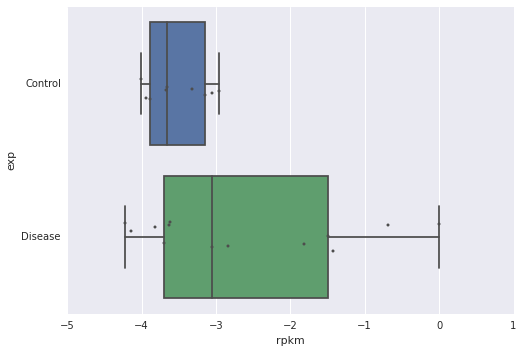

In [7]:
ax = sns.boxplot(x='rpkm', y='exp', data=scores)
sns.stripplot(x='rpkm', y='exp', data=scores,
              jitter=True, size=3, color=".3", linewidth=0)

In [8]:
ctrl, disease = list(scores.groupby("exp"))
ttest_ind(ctrl[1].rpkm, disease[1].rpkm)

Ttest_indResult(statistic=-1.7929213770446888, pvalue=0.088124275073685657)

#filer out strange samples

In [9]:
filtered_scores = scores[~scores.id.isin('21 79 42 44'.split())]


In [10]:
scores[scores.id.isin('21 79 42 44'.split())]

,,rpkm,exp,id
id,exp,,,
21,Disease,-4.224996,Disease,21
42,Control,-3.149980,Control,42
44,Control,-3.324387,Control,44
79,Disease,-4.148113,Disease,79


In [11]:
scores.groupby("exp").mean()

,rpkm
exp,
Control,-3.517508
Disease,-2.648867


In [12]:
scores[~scores.id.isin('21 79 42 44'.split())].groupby("exp").mean()

,rpkm
exp,
Control,-3.597601
Disease,-2.369287


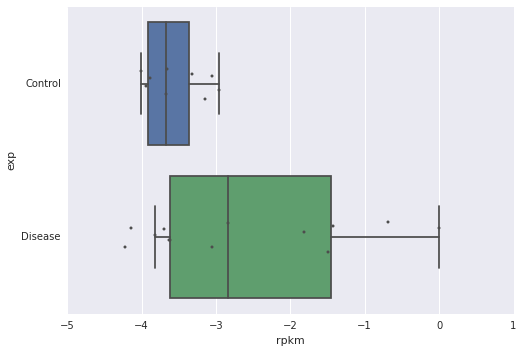

In [13]:
filtered_scores = scores[~scores.id.isin('21 79 42 44'.split())]

ax = sns.boxplot(x='rpkm', y='exp', data=filtered_scores)
sns.stripplot(x='rpkm', y='exp', data=scores,
              jitter=True, size=3, color=".3", linewidth=0)

In [14]:
ctrl, disease = list(filtered_scores.groupby("exp"))
ttest_ind(ctrl[1].rpkm, disease[1].rpkm)

Ttest_indResult(statistic=-2.3217372627013635, pvalue=0.033768993430172381)

#Process Counts

In [15]:
counts = pd.read_table("/nas3/gpratt/Dropbox/TAF15/Data/sALS/all_counts.txt", skiprows=1, index_col=0)
counts.columns = [os.path.basename(item).split(".")[0] for item in counts.columns]

metadata = counts.columns[5:]
results = {}
for item in metadata:
    split_item = item.split("_")[1]
    sample_id = split_item[:-1]
    condition = "control" if split_item[-1] == "C" else "disease"
    results[item] = {"sample_id": sample_id, "condition": condition}
    
metadata = pd.DataFrame(results).T
metadata.index.names = ['id']
rpkms = helpers.counts_to_rpkm(counts)

In [16]:
counts.ix[:,metadata.index].to_csv("/nas3/gpratt/Dropbox/TAF15/Data/sALS/important_counts.csv")
metadata.to_csv("/nas3/gpratt/Dropbox/TAF15/Data/sALS/metadata.csv")

VIA doing PCA in DESeq2 I think I get already seperation, especially if I get rid of one outlyer 

In [17]:
sALS = pd.read_csv("/nas3/gpratt/Dropbox/TAF15/Data/sALS/sALS.csv", index_col=0)
sALS.index.names = ["gene_id"]
sALS['gene_name'] = [gene_id_to_name[gene_id] for gene_id in sALS.index]

new_index = []
for index in sALS.index:
    new_index.append(['mn', 'sALS', index])
sALS.index = pd.MultiIndex.from_tuples(new_index)

significant_sALS = sALS[(sALS.padj <= .05) & (abs(sALS.log2FoldChange) > np.log2(1.5))]
significant_sALS_upregulated = significant_sALS[significant_sALS.log2FoldChange > 0]
significant_sALS_downregulated = significant_sALS[significant_sALS.log2FoldChange < 0]

In [18]:
metadata['short_name'] = metadata.index.map(lambda x: x.split("_")[1])

In [92]:
gene_name_counts = counts.copy()
gene_name_counts.index = [gene_id_to_name[item] for item in gene_name_counts.index]

In [95]:
gene_name_counts.to_csv("/nas3/gpratt/Dropbox/TAF15/Data/sALS/all_counts_gene_name.txt")

In [19]:
filtered_rpkms = rpkms.ix[significant_sALS.index.get_level_values(level=2)]

In [20]:
filtered_rpkms = filtered_rpkms.drop(["ssRNAseq_42C", 
                     "ssRNAseq_79A", 
                     "ssRNAseq_21A",
                     "ssRNAseq_63A", 
                     "ssRNAseq_44C"], axis=1)

In [21]:
color_map = {"control": sns.color_palette(palette="Set1", n_colors=2)[0],
 "disease": sns.color_palette(palette="Set1", n_colors=2)[1]}


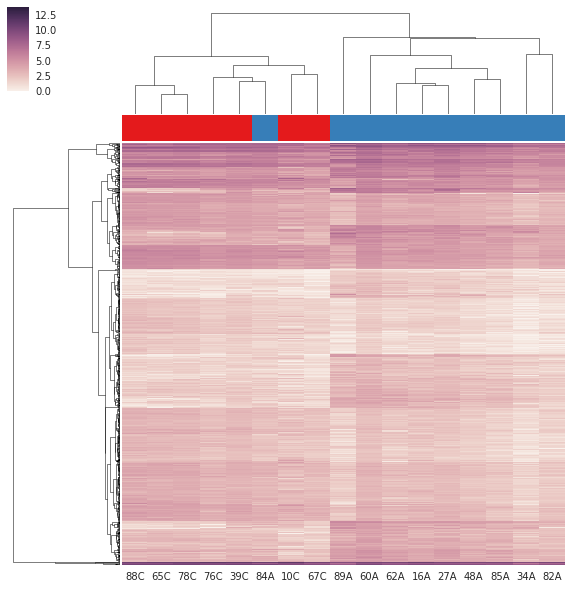

In [89]:
fig = sns.clustermap(np.log2(filtered_rpkms[filtered_rpkms > 1].dropna()), 
                     yticklabels=False,
                     col_colors=metadata.ix[filtered_rpkms.columns].condition.map(color_map),
                     linewidths=0,
                     xticklabels=metadata.ix[filtered_rpkms.columns].short_name
                    )

fig.savefig(os.path.join(img_dir, "sALS_clustering.svg"), figsize=(3,3))

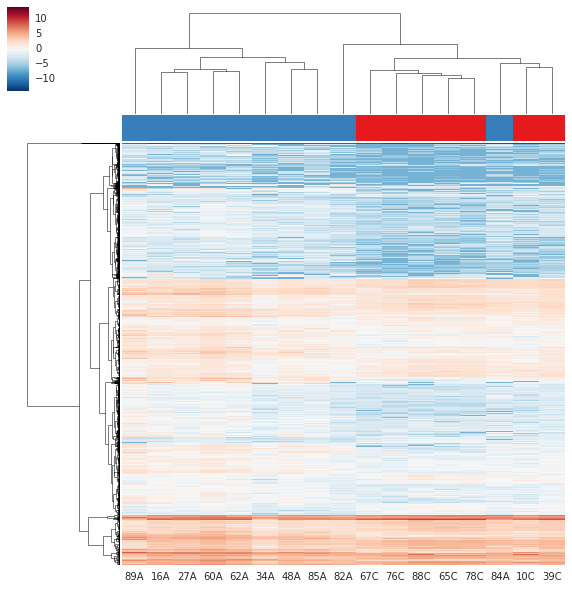

In [80]:
fig = sns.clustermap(np.log2(filtered_rpkms + .01), 
                     yticklabels=False,
                     col_colors=metadata.ix[filtered_rpkms.columns].condition.map(color_map),
                     linewidths=0,
                     xticklabels=metadata.ix[filtered_rpkms.columns].short_name
                    )

fig.savefig(os.path.join(img_dir, "sALS_clustering.svg"), figsize=(3,3))

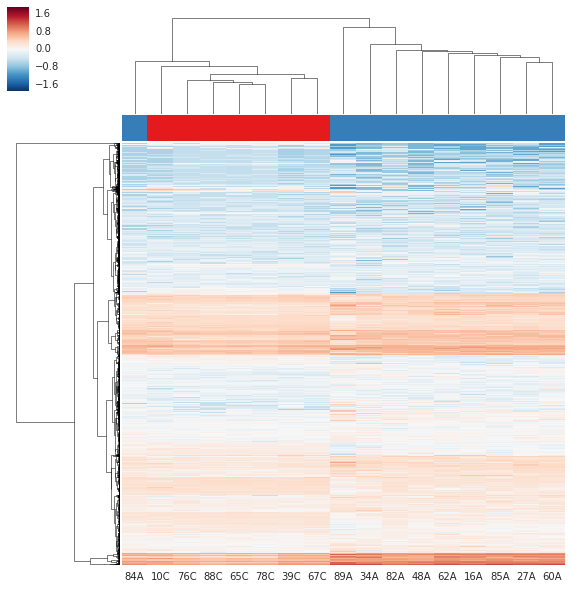

In [83]:
fig = sns.clustermap(np.log2(filtered_rpkms + .01), 
                     yticklabels=False,
                     col_colors=metadata.ix[filtered_rpkms.columns].condition.map(color_map),
                     linewidths=0,
                     xticklabels=metadata.ix[filtered_rpkms.columns].short_name,
                     z_score=1
                    )

fig.savefig(os.path.join(img_dir, "sALS_clustering.svg"), figsize=(3,3))

In [85]:
sns.clustermap?

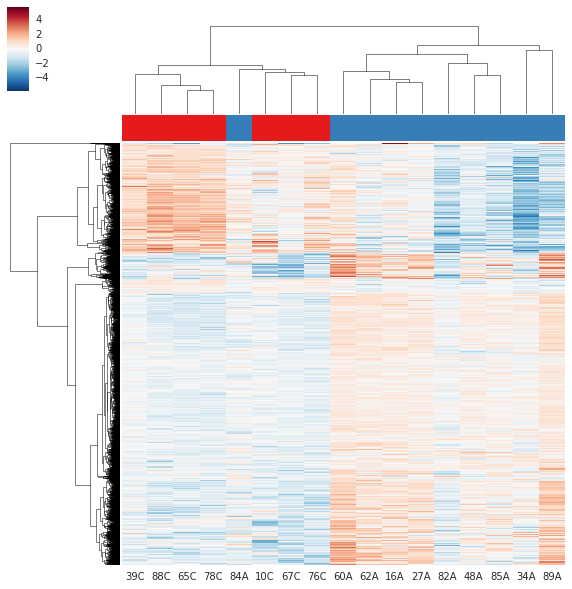

In [84]:
fig = sns.clustermap(np.log2(filtered_rpkms + .01), 
                     yticklabels=False,
                     col_colors=metadata.ix[filtered_rpkms.columns].condition.map(color_map),
                     linewidths=0,
                     xticklabels=metadata.ix[filtered_rpkms.columns].short_name,
                     z_score=0
                    )

fig.savefig(os.path.join(img_dir, "sALS_clustering.svg"), figsize=(3,3))

#Look at just the 96 Gene pannel 

In [23]:
neuron_markers = pd.read_excel("/nas3/gpratt/Dropbox/TAF15/Data/mouse_integration/13-02-12 Neuron 96 marker panel.xlsx", "Sheet2").dropna()

name_to_gene_id = {value: key for key, value in gene_id_to_name.items()} 
ensembl_to_refseq = pd.read_table("/nas3/gpratt/Dropbox/TAF15/Data/mouse_integration/ensembl_to_refseq.txt.gz").dropna()
refseq_to_gencode = {row['RefSeq mRNA [e.g. NM_001195597]']: row['Ensembl Gene ID'] for name, row in ensembl_to_refseq.iterrows()}
ensembl_to_refseq = {value: key for key, value in refseq_to_gencode.items()} 
ensembl_to_gencode = {key.split(".")[0]: key for key in gene_id_to_name}

NM_006158


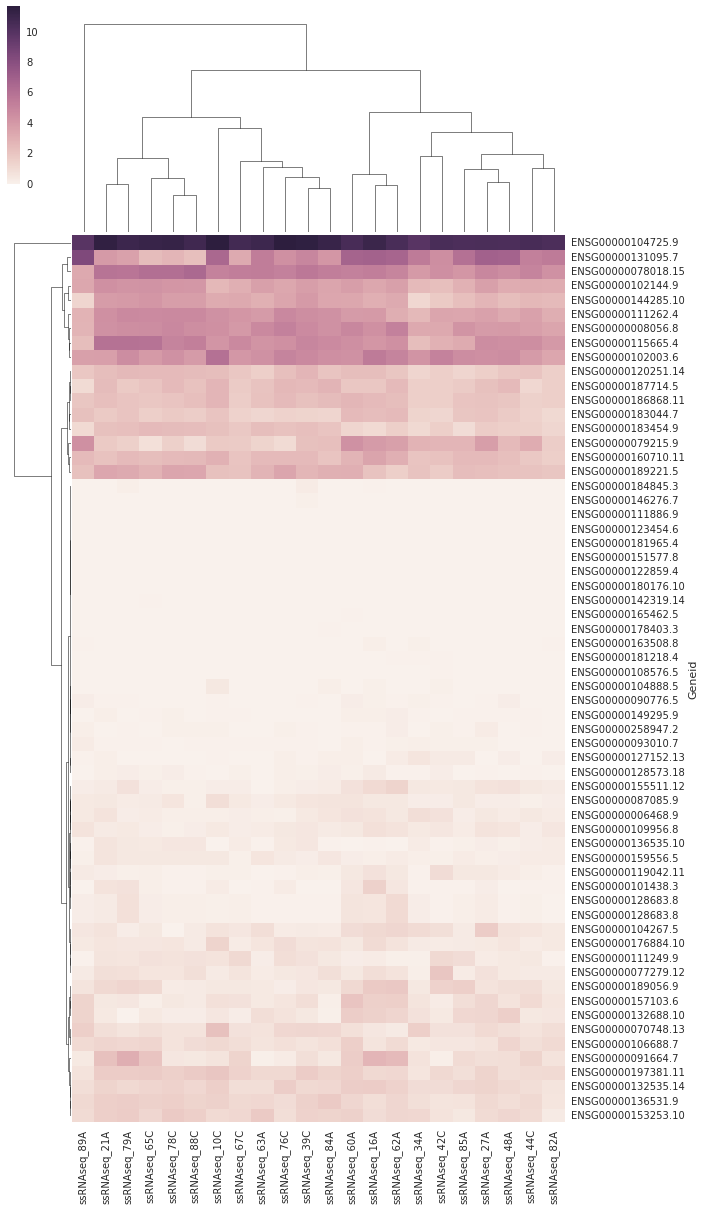

In [86]:
sns.clustermap(np.log2(rpkms.ix[neuron_markers.gencode_id] + 1), figsize=(10,20))